copied from https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding

In [45]:
!pip install openai
!pip install -U openai-whisper

!sudo apt update
!sudo apt install ffmpeg

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
f

In [54]:
!pip install opencv-python

In [49]:
!wget https://raw.githubusercontent.com/dhrim/2024_kangnam_hallym_workshop/main/material/data/bison.mp4 -O bison.mp4

--2024-07-11 10:11:00--  https://raw.githubusercontent.com/dhrim/2024_kangnam_hallym_workshop/main/material/data/bison.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2614862 (2.5M) [application/octet-stream]
Saving to: ‘bison.mp4’

bison.mp4           100%[===================>]   2.49M  --.-KB/s    in 0.07s   

2024-07-11 10:11:00 (33.3 MB/s) - ‘bison.mp4’ saved [2614862/2614862]



In [62]:
from openai import OpenAI

client = OpenAI(api_key="")

# 동영상 로딩하여 각 프레임으로 쪼개기

In [55]:
from IPython.display import display, Image, Audio

import cv2
import base64
import time
from openai import OpenAI
import os
import requests

In [56]:
video = cv2.VideoCapture("bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

618 frames read.


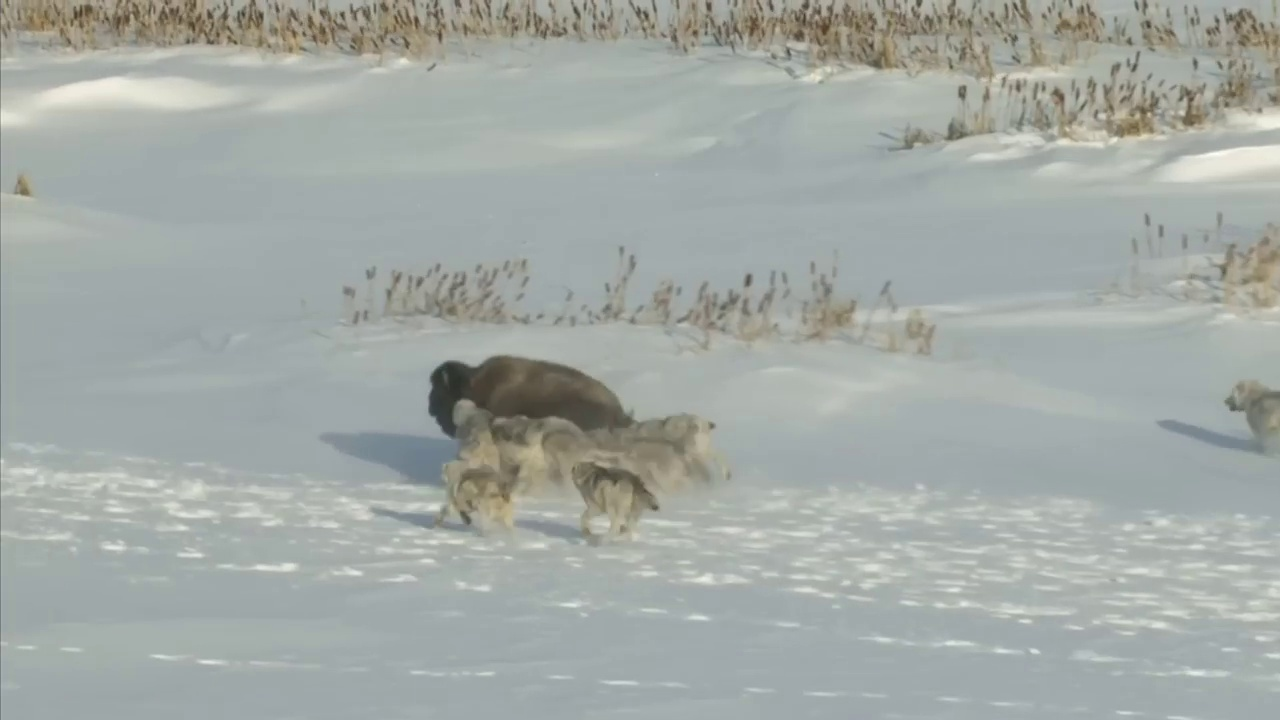

In [59]:
display_handle.update(Image(data=base64.b64decode(base64Frames[10].encode("utf-8"))))

# 동영상에 맞는 narration 생성

In [63]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "이 영상의 프레임들을 업로드하고 싶습니다. 영상과 함께 업로드할 수 있는 매력적인 설명을 한글로 생성해 주세요.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

response = client.chat.completions.create(**params)
narration = response.choices[0].message.content

print(narration)

이 영상은 겨울의 눈 덮인 황야에서 펼쳐지는 자연의 생존 경쟁을 포착한 장면입니다. 늑대 무리가 들소를 사냥하는 과정을 통해 자연 세계의 냉혹한 현실과 생명의 순환을 생생하게 보여줍니다. 늑대들의 조직적이고 협력적인 사냥 방식, 그리고 들소의 필사적인 저항이 눈부신 설경 속에서 긴장감을 높입니다. 자연의 웅장함과 잔인함을 동시에 느낄 수 있는 이 영상은 시청자들에게 깊은 인상을 남길 것입니다.


# 텍스트에서 음성 생성

In [69]:
response = client.audio.speech.create(
    model="tts-1",
    voice="alloy",
    input=narration
)

response.stream_to_file("narration.mp3")

<ipython-input-69-17dcf09e961c>:7: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file("output.mp3")


In [70]:
with client.audio.speech.with_streaming_response.create(
    model="tts-1",
    voice="alloy",
    input=narration,
) as response:
    response.stream_to_file("narration.mp3")

In [71]:
from IPython.display import Audio, display

display(Audio("narration.mp3", autoplay=True))